# Using `icepyx` to access Icesat-2 data

In [1]:
!pip install icepyx==0.8.1 -qq

## What is Icesat-2?

![IS2](https://icesat-2.gsfc.nasa.gov/sites/default/files/MissionLogo_0.png)

Icesat-2 is a satellite lidar instrument. Lidar is an active remote sensing instrument in which pulses of light are emitted and the return time is used to mesure distance. The available Icesat-2 data products range from sea ice freeboard to land elevation to cloud backscatter characteristics. A list of availble products can be found [here](https://icesat-2.gsfc.nasa.gov/science/data-products). In this tutorial we will look at `ATL08` Land Water Vegetation Elevation.

### Data Collection

Icesat-2 measures data along 6 different beams: 3 strong beams and 3 weak beams. The strong and weak beams are calibrated such that the weak beams have more sensitivity to viewing very bright surfaces (Ex. ice), which the strong beams are able to view surfaces with lower reflectances (Ex. water). The beams are called `gt1l`, `gt1r`, `gt2l`, `gt2r`, `gt3l`, and `gt3r`, where the `l` and `r` denotes whether the beam was strong or weak.

**Jessica** which one (l/r) is which? Or is this is what spot is for?

![Tracks](https://ars.els-cdn.com/content/image/1-s2.0-S0034425718305066-gr1.jpg)

Photo: Neuenschwander et. al. 2019, Remote Sens. Env. [DOI](https://doi.org/10.1016/j.rse.2018.11.005)

### Counting Photons

The Icesat-2 lidar collects at the single photon level, different from most commercial lidar systems. A lot of additional photons get returned as solar background noise, and removing these unwanted photons is a key part of the algorithms that produce the higher level data products.

<img src=".images/ATL08_signalphotons.jpg" width=450/>

> _Fig. 2. Results from signal finding methods for simulated ATLAS data. Black points show raw point cloud data as ingested from ATL03 product. Blue points overlaid in each plot show which photons each method identified as signal. Top panel reflects the signal photons as identified on the ATL03 data product (medium and high confidence signal photons). Bottom panel reflects the signal photons identified from the ATL08 DRAGANN method._ (Neuenschwander & Pitts, 2019)
Photo: Neuenschwander et. al. 2019, Remote Sens. Env. [DOI](https://doi.org/10.1016/j.rse.2018.11.005)

**Jessica** Do you understand how there could be photons returns that register a height below the ground?

To aggregate all these photons into more manegable chunks ATL08 consolidates the photons into 100m segments, each made up of five 20m segments.

## What is `icepyx`?

<img src="https://icepyx.readthedocs.io/en/latest/_static/icepyx_v2_oval_orig_nobackgr.png" width=350/>

icepyx is a community built library for searching, downloading, and reading Icesat-2 data. While opening data should be straightforward, there are some oddities in navigating the organization of the Icesat-2 data. icepyx provides tools to help with those oddities.

### Fitting icepyx into the data access package landscape

For Icesat-2 data, the icepyx package can:
- search for available data granules (data files)
- order and download data
- order a subset of data: either clipped in space or containing fewer variables
- provides functionality to search through the available data variables
- read Icesat-2 data into xarray DataArrays, including merging data from multiple files

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
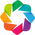

In [2]:
import icepyx as ipx

In [33]:
import json

import matplotlib.pyplot as plt
from shapely.geometry import shape, GeometryCollection

In [43]:
%matplotlib inline

### Using icepyx to search for data

We won't dive into using icepyx to search for and download data in this tutorial, since we already discussed how to do that with `earthaccess`. The code to search and download is still provided below for the curious reader. The [icepyx documentation](https://icepyx.readthedocs.io/en/latest/example_notebooks/IS2_data_access.html) shows more detail about different search parameters and how to inspect the results of a query.

**Jessica** icepyx does not search by roi, correct?

In [4]:
# Open a geojson of our area of interest
with open("bosque_primavera.json") as f:
    features = json.load(f)["features"]

bosque = GeometryCollection([shape(feature["geometry"]).buffer(0) for feature in features])

In [5]:
# Use our search parameters to setup a search Query
short_name = 'ATL08'
spatial_extent = list(bosque.bounds)
date_range = ['2019-05-04','2019-05-04']
region = ipx.Query(short_name, spatial_extent, date_range)

In [6]:
# Display if any data files, or granules, matched our search
region.avail_granules(ids=True)

[['ATL08_20190504124152_05540301_006_02.h5']]

In [7]:
# Download the granules to a into a folder called 'bosque_primavera_ATL08'
region.download_granules('./bosque_primavera_ATL08')

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)
You're now authenticated with NASA Earthdata Login
Using token with expiration date: 12/15/2023
Using .netrc file for EDL
Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000004609941
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000004609941 of  1  order(s) is downloaded.
Download complete


<div class="alert alert-block alert-info">
<b>Tip:</b> If you don't want to type your earthdata login information every time they are
    required you can setup more automatic methods of authentication. Two common methods
    are 1) Add your earthdata password and username to as environment variables
    as EARTHDATA_USERNAME and EARTHDATA_PASSWORD. 2) setup a .netrc file in your home directory. See <a href="https://nasa-openscapes.github.io/2021-Cloud-Hackathon/tutorials/04_NASA_Earthdata_Authentication.html"> the Openscapes tutorial</a> </div>

## Reading a file with icepyx

To read a file with icepyx there are several steps:
1. Create a `Read` object. This sets up an initial connection to your file(s) and validates the metadata.
2. Tell the `Read` object what variables you would like to read
3. Load your data!

### Create a `Read` object

In [8]:
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"
reader = ipx.Read('./bosque_primavera_ATL08', "ATL08", pattern)

You have 1 files matching the filename pattern to be read in.


In [9]:
reader

### Select your variables

To view the variables contained in your dataset you can call `.vars` on your data reader.

In [10]:
reader.vars.avail()

['ancillary_data/atlas_sdp_gps_epoch',
 'ancillary_data/control',
 'ancillary_data/data_end_utc',
 'ancillary_data/data_start_utc',
 'ancillary_data/end_cycle',
 'ancillary_data/end_delta_time',
 'ancillary_data/end_geoseg',
 'ancillary_data/end_gpssow',
 'ancillary_data/end_gpsweek',
 'ancillary_data/end_orbit',
 'ancillary_data/end_region',
 'ancillary_data/end_rgt',
 'ancillary_data/granule_end_utc',
 'ancillary_data/granule_start_utc',
 'ancillary_data/land/atl08_region',
 'ancillary_data/land/bin_size_h',
 'ancillary_data/land/bin_size_n',
 'ancillary_data/land/bright_thresh',
 'ancillary_data/land/ca_class',
 'ancillary_data/land/can_noise_thresh',
 'ancillary_data/land/can_stat_thresh',
 'ancillary_data/land/canopy20m_thresh',
 'ancillary_data/land/canopy_flag_switch',
 'ancillary_data/land/canopy_seg',
 'ancillary_data/land/class_thresh',
 'ancillary_data/land/cloud_filter_switch',
 'ancillary_data/land/del_amp',
 'ancillary_data/land/del_mu',
 'ancillary_data/land/del_sigma',


Thats **a lot** of variables!

One key feature of icepyx is the ability to browse the variables available in the dataset. There are typically hundreds of variables in a single dataset, so that is a lot to sort through! Let's take a moment to get oriented to the organization of ATL08 variables, by first a few important pieces of the algorithm.

To create higher level variables like canopy or terrain height, the ATL08 algorithms goes through a series of steps:
1. Identify signal photons from noise photons
2. Classify each of the signal photons as either terrain, canopy, or canopy top
3. Remove elevation, so the heights are with respect to the ground
3. Group the signal photons into 100m segments. If there are a sufficient number of photons in that group, calculate statistics for terrain and canopy (ex. mean height, max height, standard deviation, etc.)


<img src=".images/ATL08_photon_classification_example.jpg" width=450/>

> _Fig. 4. An example of the classified photons produced from the ATL08 algorithm. Ground photons (red dots) are labeled as all photons falling within a point spread function distance of the estimated ground surface. The top of canopy photons (green dots) are photons that fall within a buffer distance from the upper canopy surface, and the photons that lie between the top of canopy surface and ground surface are labeled as canopy photons (blue dots)._ (Neuenschwander & Pitts, 2019)

Providing all the potentially useful information from all these processing steps results in a data file that looks like:

<img src=".images/ATL08_structure.png" width=650/>

Another way to visualize these structure is to download one file and open it using https://myhdf5.hdfgroup.org/. 

Further information about each one of the variables is available in the [Algorithm Theoretical Basis Document (ATBD)](https://icesat-2.gsfc.nasa.gov/sites/default/files/page_files/ICESat2_ATL08_ATBD_r006.pdf) for ATL08.

There is lots to explore in these variables, but we will move forward using a common ATL08 variable: `h_canopy`, or the "98% height of all the individual relative canopy heights (height above terrain)" (ATBD definition).

In [11]:
reader.vars.append(var_list=['h_canopy', 'latitude', 'longitude'])

Note that adding variables is a required step before you can load the data.

### Load the data!

In [12]:
ds = reader.load()
ds

/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photon_idx' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({"delta_time": "photon_idx"})
/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photon_idx' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({"delta_time": "photon_idx"})


<xarray.Dataset>
Dimensions:              (gran_idx: 1, photon_idx: 211, spot: 2)
Coordinates:
  * gran_idx             (gran_idx) float64 5.54e+04
  * photon_idx           (photon_idx) int64 0 1 2 3 4 5 ... 206 207 208 209 210
  * spot                 (spot) uint8 1 2
    source_file          (gran_idx) <U74 './bosque_primavera_ATL08/processed_...
    delta_time           (photon_idx) datetime64[ns] 2019-05-04T12:47:13.5766...
Data variables:
    sc_orient            (gran_idx) int8 0
    cycle_number         (gran_idx) int8 3
    rgt                  (gran_idx, spot, photon_idx) float32 554.0 ... 554.0
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18
    data_start_utc       (gran_idx) datetime64[ns] 2019-05-04T12:46:31.876322
    data_end_utc         (gran_idx) datetime64[ns] 2019-05-04T12:48:54.200826
    latitude             (spot, gran_idx, photon_idx) float32 20.59 ... 20.73
    longitude            (spot, gran_idx, photon_idx) float32 -103.7 ... -103.7
    gt                   (gran_idx, spot) object 'gt3l' 'gt3r'
    h_canopy             (photon_idx) float32 12.12 4.747 11.83 ... nan nan nan
Attributes:
    data_product:  ATL08
    Description:   Contains data categorized as land at 100 meter intervals.
    data_rate:     Data are stored as aggregates of 100 meters.

Here we have an xarray Dataset, a common Python data structure for analysis. To visualize the data we can plot it using:

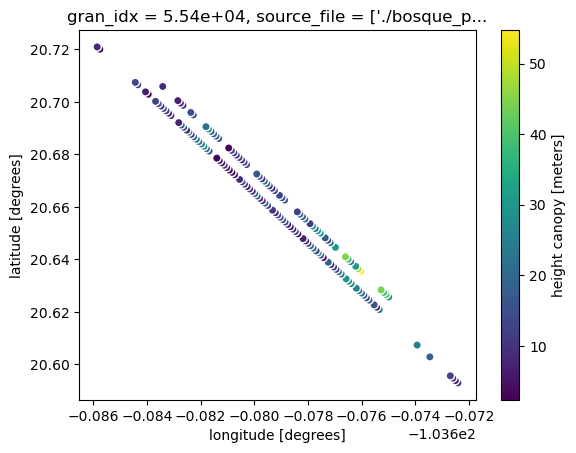

In [14]:
ds.plot.scatter(x="longitude", y="latitude", hue="h_canopy")

Notice also that the data is shown for just our area of interest! That is because of icepyx's subsetting feature, which we will discuss more in the next section.

## Using icepyx to download a subset of a granule

One feature which is not yet available in earthaccess is the ability to download just a subset of the file. This could mean a smaller spatial area or fewer variables. This feature is available in icepyx.

We saw above that icepyx by default will subset your data to the bounding box you provided when downloading. If you know in advance which variables you want icepyx can also subset variables.

### Subset variables

In [23]:
# Create our Query
short_name = 'ATL08'
spatial_extent = list(bosque.bounds)
date_range = ['2019-05-04','2019-05-04']
region = ipx.Query(short_name, spatial_extent, date_range)

In [24]:
# Specify desired variables
region.order_vars.append(var_list=['h_canopy', 'latitude', 'longitude'])

We are already authenticated with NASA EDL


In [25]:
# Download the granules, using the Coverage kwarg to specify variables
region.download_granules(path='./ATL08_h_canopy', Coverage=region.order_vars.wanted)

Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000004609948
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete
Beginning download of zipped output...
Data request 5000004609948 of  1  order(s) is downloaded.
Download complete


In [26]:
# Read the new data
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"
reader = ipx.Read('./ATL08_h_canopy', "ATL08", pattern)

You have 2 files matching the filename pattern to be read in.


The available variables list on the subset dataset is a lot shorter!

In [27]:
reader.vars.avail()

['ancillary_data/atlas_sdp_gps_epoch',
 'ancillary_data/data_end_utc',
 'ancillary_data/data_start_utc',
 'ancillary_data/end_delta_time',
 'ancillary_data/granule_end_utc',
 'ancillary_data/granule_start_utc',
 'ancillary_data/start_delta_time',
 'gt3l/land_segments/canopy/h_canopy',
 'gt3l/land_segments/delta_time',
 'gt3l/land_segments/latitude',
 'gt3l/land_segments/longitude',
 'gt3r/land_segments/canopy/h_canopy',
 'gt3r/land_segments/delta_time',
 'gt3r/land_segments/latitude',
 'gt3r/land_segments/longitude',
 'orbit_info/sc_orient',
 'orbit_info/sc_orient_time']

## Some example plots

In this last section there are a few more examples of selecting ATL08 variables and plotting them to view the data.

### Example 1: View the photon classifications

In [28]:
# Set up the data reader
pattern = "processed_ATL{product:2}_{datetime:%Y%m%d%H%M%S}_{rgt:4}{cycle:2}{orbitsegment:2}_{version:3}_{revision:2}.h5"
reader = ipx.Read('./bosque_primavera_ATL08', "ATL08", pattern)

You have 1 files matching the filename pattern to be read in.


In [29]:
# Add the photon height and classification variables
reader.vars.append(var_list=['ph_h', 'classed_pc_flag', 'latitude', 'longitude'])

In [30]:
# load the dataset
ds_photons = reader.load()
ds_photons

/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photon_idx' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({"delta_time": "photon_idx"})
/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photon_idx' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({"delta_time": "photon_idx"})
/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photon_idx' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({"delta_time": "photon_idx"})
/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photo

<xarray.Dataset>
Dimensions:              (gran_idx: 1, photon_idx: 25234, spot: 2)
Coordinates:
  * gran_idx             (gran_idx) float64 5.54e+04
  * photon_idx           (photon_idx) int64 0 1 2 3 ... 25230 25231 25232 25233
  * spot                 (spot) uint8 1 2
    source_file          (gran_idx) <U74 './bosque_primavera_ATL08/processed_...
    delta_time           (photon_idx) datetime64[ns] 2019-05-04T12:47:13.5766...
Data variables:
    sc_orient            (gran_idx) int8 0
    cycle_number         (gran_idx) int8 3
    rgt                  (gran_idx, spot, photon_idx) float32 554.0 ... nan
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18
    data_start_utc       (gran_idx) datetime64[ns] 2019-05-04T12:46:31.876322
    data_end_utc         (gran_idx) datetime64[ns] 2019-05-04T12:48:54.200826
    latitude             (spot, gran_idx, photon_idx) float32 20.59 ... nan
    longitude            (spot, gran_idx, photon_idx) float32 -103.7 ... nan
    gt                   (gran_idx, spot) <U4 'gt3l' 'gt3r'
    ph_h                 (spot, gran_idx, photon_idx) float32 nan ... 0.05542
    classed_pc_flag      (spot, gran_idx, photon_idx) float32 nan nan ... 1.0
Attributes:
    data_product:  ATL08

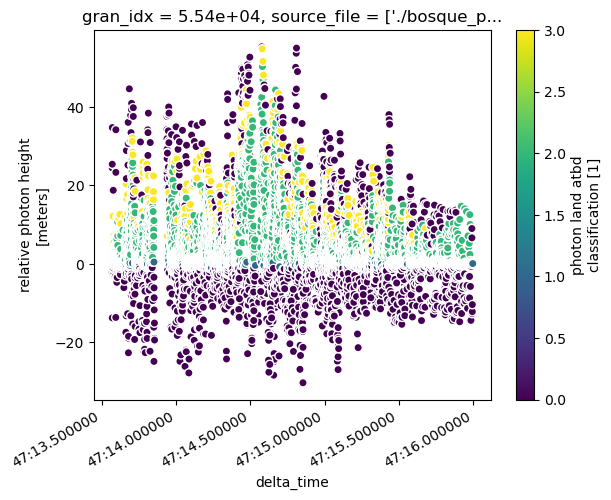

In [45]:
# plot
fig, ax = plt.subplots()

ds_photons.plot.scatter(ax=ax, x='delta_time', y='ph_h', hue='classed_pc_flag')

### Plot the canopy compared to the ground height

A nice idea, but there are a few places where the ground may be above the canopy. Not sure how to talk about that. Maybe consider if h_te_best_fit is the best variable to use for height?

In [38]:
# Remove our previous variables
reader.vars.remove(all=True)
# Add the next set of variables to the list
reader.vars.append(var_list=['h_te_best_fit', 'latitude', 'longitude'])

In [39]:
# load the data
ds_te = reader.load()
ds_te

/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photon_idx' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({"delta_time": "photon_idx"})
/srv/conda/envs/notebook/lib/python3.10/site-packages/icepyx/core/read.py:520: UserWarning: rename 'delta_time' to 'photon_idx' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  .rename({"delta_time": "photon_idx"})


<xarray.Dataset>
Dimensions:              (gran_idx: 1, photon_idx: 211, spot: 2)
Coordinates:
  * gran_idx             (gran_idx) float64 5.54e+04
  * photon_idx           (photon_idx) int64 0 1 2 3 4 5 ... 206 207 208 209 210
  * spot                 (spot) uint8 1 2
    source_file          (gran_idx) <U74 './bosque_primavera_ATL08/processed_...
    delta_time           (photon_idx) datetime64[ns] 2019-05-04T12:47:13.5766...
Data variables:
    sc_orient            (gran_idx) int8 0
    cycle_number         (gran_idx) int8 3
    rgt                  (gran_idx, spot, photon_idx) float32 554.0 ... 554.0
    atlas_sdp_gps_epoch  (gran_idx) datetime64[ns] 2018-01-01T00:00:18
    data_start_utc       (gran_idx) datetime64[ns] 2019-05-04T12:46:31.876322
    data_end_utc         (gran_idx) datetime64[ns] 2019-05-04T12:48:54.200826
    latitude             (spot, gran_idx, photon_idx) float32 20.59 ... 20.73
    longitude            (spot, gran_idx, photon_idx) float32 -103.7 ... -103.7
    gt                   (gran_idx, spot) object 'gt3l' 'gt3r'
    h_te_best_fit        (photon_idx) float32 1.342e+03 1.34e+03 ... 1.381e+03
Attributes:
    data_product:  ATL08
    Description:   Contains data categorized as land at 100 meter intervals.
    data_rate:     Data are stored as aggregates of 100 meters.

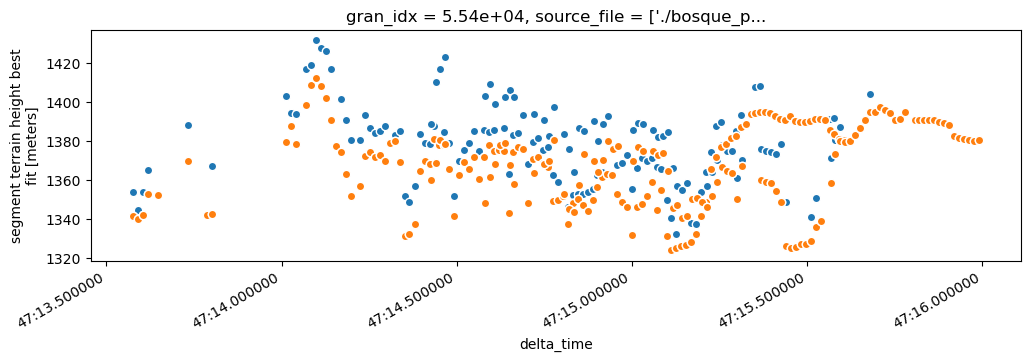

In [46]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 3)

# plot the canopy height above ground level
(ds.h_canopy + ds_te.h_te_best_fit).plot.scatter(ax=ax, x="delta_time", y="h_canopy") # orange

# plot the terrain values
ds_te.plot.scatter(ax=ax, x="delta_time", y="h_te_best_fit") # blue

## Other ideas for a fun last thing but will likely get dropped 

Trying to come up with a fun final plot, if there is time. Ignore this for now and revisit in the morning.

### Add more of a basemap to the spatial plot

Cartopy doesn't seem to have any nice built in basemaps, and I think foluim would be too complicated.

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Add background features
ax.add_feature(cfeature.COASTLINE, alpha=0.3)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.RIVERS)

# ax.set_extent([-77.5, -75.4, 36.6, 39.7])

# Add and format gridlines. Remove top and right labels
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.2, linestyle='--')
gl.top_labels, gl.right_labels = False, False

ds.plot.scatter(ax=ax, x="longitude", y="latitude", hue="h_canopy")

Notice that the data is already subset to our area of interest! (Also download the full granule with earthaccess to compare the area?)

### Interactive plot with holoviz

In [47]:
import hvplot.xarray

In [48]:
ds.hvplot.scatter(y="h_canopy", x="latitude",
                  by=['spot', 'photon_idx', 'gran_idx'], legend=False)

:NdOverlay   [spot,photon_idx,gran_idx]
   :Scatter   [latitude]   (h_canopy)

In [49]:
gt1l = ds.where(ds.gt == 'gt1l')